# Useful tutorials

## General overviews of functions:
https://nilearn.github.io/stable/manipulating_images/masker_objects.html  
https://nilearn.github.io/stable/connectivity/functional_connectomes.html  

## Specific example applications:
https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_signal_extraction.html  
https://nilearn.github.io/stable/auto_examples/06_manipulating_images/plot_nifti_labels_simple.html  
https://nilearn.github.io/stable/auto_examples/06_manipulating_images/plot_extract_rois_statistical_maps.html  
https://nilearn.github.io/stable/auto_examples/06_manipulating_images/plot_mask_computation.html  


Workflow to create an apply amygdala masker

In [1]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
import numpy as np
import nibabel as nib

def create_label_masker(atlas_name, label_keywords, standardize=True, **masker_kwargs):
    """
    Create a NiftiLabelsMasker with only specified labels from a Harvard-Oxford atlas.
    
    Parameters
    ----------
    atlas_name : str
        Name of the Harvard-Oxford atlas to load.
        Options: 'cort-maxprob-thr25-2mm', 'sub-maxprob-thr25-2mm', etc.
    label_keywords : str or list of str
        Keyword(s) to search for in label names (case-insensitive).
        Can be a single string or list of strings.
    standardize : bool, default=True
        Whether to standardize the timeseries.
    **masker_kwargs : dict
        Additional keyword arguments to pass to NiftiLabelsMasker.
    
    Returns
    -------
    masker : NiftiLabelsMasker
        Masker with only the specified labels.
    selected_labels : list
        List of label names that were selected.
    selected_indices : list
        List of indices corresponding to the selected labels.
    
    Examples
    --------
    >>> masker, labels, indices = create_label_masker('sub-maxprob-thr25-2mm', 'amygdala')
    >>> masker, labels, indices = create_label_masker('cort-maxprob-thr25-2mm', ['frontal', 'temporal'])
    """
    # Load atlas
    dataset = datasets.fetch_atlas_harvard_oxford(atlas_name)
    atlas_img = dataset.maps  # This is already a Nifti1Image object
    labels = dataset.labels
    
    # Ensure label_keywords is a list
    if isinstance(label_keywords, str):
        label_keywords = [label_keywords]
    
    # Find matching labels and their indices
    selected_labels = []
    selected_indices = []
    
    for i, label in enumerate(labels):
        if any(keyword.lower() in label.lower() for keyword in label_keywords):
            selected_labels.append(label)
            selected_indices.append(i)
    
    if not selected_labels:
        raise ValueError(f"No labels found matching keywords: {label_keywords}")
    
    print(f"Selected labels: {selected_labels}")
    print(f"Selected indices: {selected_indices}")
    
    # Get the atlas data
    atlas_data = atlas_img.get_fdata()
    
    # Create a new mask with only selected regions
    selected_mask = np.zeros_like(atlas_data)
    for idx in selected_indices:
        selected_mask[atlas_data == idx] = idx
    
    # Create new image with just selected regions
    selected_img = nib.Nifti1Image(selected_mask, atlas_img.affine, atlas_img.header)
    
    # Create the masker
    masker = NiftiLabelsMasker(
        labels_img=selected_img,
        labels=selected_labels,
        standardize=standardize,
        **masker_kwargs
    )
    
    return masker, selected_labels, selected_indices


# Example usage:
masker, labels, indices = create_label_masker('sub-maxprob-thr25-2mm', 'amygdala')

[fetch_atlas_harvard_oxford] Dataset found in /Users/zenkavi/nilearn_data/fsl
Selected labels: ['Left Amygdala', 'Right Amygdala']
Selected indices: [10, 20]


How big are these ROIs?

In [2]:
# You need to fit the masker first
masker.fit()

# Now you can access the labels_img_
labels_data = masker.labels_img_.get_fdata()

# Count voxels in each ROI
for i, label in enumerate(masker.labels_[1:]):
    n_voxels = np.sum(labels_data == indices[i])
    print(f"{label}: {n_voxels} voxels")

10.0: 306 voxels
20.0: 366 voxels


In [3]:
fmri_data = '/Users/zenkavi/Documents/EnkaviLab/data/ds004892/derivatives/preprocessing/sub-S01/ses-1/func/sub-S01_ses-1_task-BigBuckBunny_space-MNI_desc-ppres_bold.nii.gz'
masked_ave_data = masker.fit_transform(fmri_data)

In [4]:
masked_ave_data.shape

(528, 2)

The two columns are for the two amygdala labels (Left Amygdala and Right Amygdala). Each column represents the extracted signal from one ROI.

How voxels in an ROI are combined: By default, NiftiLabelsMasker uses averaging (strategy='mean'). You can change this behavior when creating the masker.

In [5]:
masked_ave_data

array([[-1.8710502 , -2.772379  ],
       [-2.4857316 , -2.4136744 ],
       [-0.5602113 , -0.9375356 ],
       ...,
       [-0.33290026, -0.65522015],
       [-0.8541835 , -0.47690973],
       [ 0.40592277,  1.3426219 ]], shape=(528, 2), dtype=float32)

If you want to get data from all individual voxels in each ROI rather than the mean, you should use `NiftiMasker` instead of `NiftiLabelsMasker`

In [6]:
from nilearn.maskers import NiftiMasker
import numpy as np
import nibabel as nib

def create_voxel_masker(atlas_name, label_keywords, standardize=True, **masker_kwargs):
    """
    Create a NiftiMasker that extracts all voxels from specified labels.
    
    Returns
    -------
    masker : NiftiMasker
        Masker that will extract all individual voxels.
    selected_labels : list
        List of label names that were selected.
    n_voxels_per_label : dict
        Dictionary mapping label names to number of voxels.
    """
    from nilearn import datasets
    
    # Load atlas
    dataset = datasets.fetch_atlas_harvard_oxford(atlas_name)
    atlas_img = dataset.maps
    labels = dataset.labels
    
    # Ensure label_keywords is a list
    if isinstance(label_keywords, str):
        label_keywords = [label_keywords]
    
    # Find matching labels and their indices
    selected_labels = []
    selected_indices = []
    
    for i, label in enumerate(labels):
        if any(keyword.lower() in label.lower() for keyword in label_keywords):
            selected_labels.append(label)
            selected_indices.append(i)
    
    if not selected_labels:
        raise ValueError(f"No labels found matching keywords: {label_keywords}")
    
    print(f"Selected labels: {selected_labels}")
    print(f"Selected indices: {selected_indices}")
    
    # Get the atlas data
    atlas_data = atlas_img.get_fdata()
    
    # Create a binary mask with all selected regions
    binary_mask = np.zeros_like(atlas_data)
    n_voxels_per_label = {}
    
    for idx, label in zip(selected_indices, selected_labels):
        roi_voxels = (atlas_data == idx)
        binary_mask[roi_voxels] = 1
        n_voxels_per_label[label] = np.sum(roi_voxels)
        print(f"{label}: {n_voxels_per_label[label]} voxels")
    
    # Create binary mask image
    mask_img = nib.Nifti1Image(binary_mask, atlas_img.affine, atlas_img.header)
    
    # Create the masker - this will extract ALL voxels
    masker = NiftiMasker(
        mask_img=mask_img,
        standardize=standardize,
        **masker_kwargs
    )
    
    return masker, selected_labels, n_voxels_per_label


# Example usage:
masker, labels, n_voxels = create_voxel_masker('sub-maxprob-thr25-2mm', 'amygdala')

[fetch_atlas_harvard_oxford] Dataset found in /Users/zenkavi/nilearn_data/fsl
Selected labels: ['Left Amygdala', 'Right Amygdala']
Selected indices: [10, 20]
Left Amygdala: 306 voxels
Right Amygdala: 366 voxels


You'll get shape (n_TRs, total_n_voxels) instead of (n_TRs, n_labels)

In [7]:
masked_raw_data = masker.fit_transform(fmri_data)

/Users/zenkavi/.pyenv/versions/dartbrains/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


In [8]:
masked_raw_data.shape

(528, 672)

In [9]:
masked_raw_data

array([[-0.39415327, -0.7478177 , -0.68301296, ...,  0.33473915,
         0.48962185,  0.5218222 ],
       [-0.29112408, -0.59726006, -0.81555784, ...,  0.52847743,
         0.13067393, -0.21980302],
       [-0.89190793, -0.8151576 , -1.2667562 , ..., -0.26170328,
        -0.7244899 , -0.7434221 ],
       ...,
       [ 1.0061921 ,  0.9128221 ,  0.45493662, ..., -0.34520108,
         0.37026256,  0.9465369 ],
       [ 0.05246604,  0.06242079,  0.37774873, ...,  0.30037448,
         0.7418162 ,  0.8920569 ],
       [-0.2601014 , -0.5533654 ,  0.51460886, ...,  2.4837422 ,
         3.1483207 ,  3.2761645 ]], shape=(528, 672), dtype=float32)

How do I know which column corresponds to which voxel?

In [10]:
# After fitting the masker
masker.fit()

# Get the mask as a boolean array
mask_data = masker.mask_img_.get_fdata().astype(bool)

# Get the indices of True voxels (in i, j, k coordinates)
voxel_indices = np.argwhere(mask_data)
print(f"Voxel coordinates shape: {voxel_indices.shape}")  # (n_voxels, 3)

# Each row is [i, j, k] coordinates for one voxel
# Column 0 in your data corresponds to voxel at voxel_indices[0]
# Column 1 in your data corresponds to voxel at voxel_indices[1], etc.

# You can also convert to MNI coordinates
from nilearn.image import coord_transform
affine = masker.mask_img_.affine
mni_coords = [coord_transform(i, j, k, affine) for i, j, k in voxel_indices]

Voxel coordinates shape: (672, 3)


In [11]:
mni_coords

[(-32.0, -4.0, -22.0),
 (-32.0, -4.0, -20.0),
 (-32.0, -2.0, -22.0),
 (-32.0, -2.0, -20.0),
 (-32.0, -2.0, -18.0),
 (-32.0, 0.0, -22.0),
 (-32.0, 0.0, -20.0),
 (-32.0, 0.0, -18.0),
 (-32.0, 0.0, -16.0),
 (-30.0, -10.0, -18.0),
 (-30.0, -8.0, -20.0),
 (-30.0, -8.0, -18.0),
 (-30.0, -6.0, -24.0),
 (-30.0, -6.0, -22.0),
 (-30.0, -6.0, -20.0),
 (-30.0, -6.0, -18.0),
 (-30.0, -4.0, -26.0),
 (-30.0, -4.0, -24.0),
 (-30.0, -4.0, -22.0),
 (-30.0, -4.0, -20.0),
 (-30.0, -4.0, -18.0),
 (-30.0, -4.0, -16.0),
 (-30.0, -2.0, -24.0),
 (-30.0, -2.0, -22.0),
 (-30.0, -2.0, -20.0),
 (-30.0, -2.0, -18.0),
 (-30.0, -2.0, -16.0),
 (-30.0, 0.0, -24.0),
 (-30.0, 0.0, -22.0),
 (-30.0, 0.0, -20.0),
 (-30.0, 0.0, -18.0),
 (-30.0, 0.0, -16.0),
 (-30.0, 0.0, -14.0),
 (-28.0, -12.0, -14.0),
 (-28.0, -10.0, -18.0),
 (-28.0, -10.0, -16.0),
 (-28.0, -10.0, -14.0),
 (-28.0, -8.0, -20.0),
 (-28.0, -8.0, -18.0),
 (-28.0, -8.0, -16.0),
 (-28.0, -8.0, -14.0),
 (-28.0, -6.0, -22.0),
 (-28.0, -6.0, -20.0),
 (-28.0, -6.0, -

In [12]:
def create_voxel_masker_with_labels(atlas_name, label_keywords, standardize=True, **masker_kwargs):
    """
    Create a NiftiMasker and track which label each voxel belongs to.
    
    Returns
    -------
    masker : NiftiMasker
    voxel_labels : list
        List where voxel_labels[i] is the label name for column i in the output
    voxel_coords : ndarray
        Array of shape (n_voxels, 3) with voxel coordinates
    """
    from nilearn import datasets
    
    # Load atlas
    dataset = datasets.fetch_atlas_harvard_oxford(atlas_name)
    atlas_img = dataset.maps
    labels = dataset.labels
    
    # Ensure label_keywords is a list
    if isinstance(label_keywords, str):
        label_keywords = [label_keywords]
    
    # Find matching labels and their indices
    selected_labels = []
    selected_indices = []
    
    for i, label in enumerate(labels):
        if any(keyword.lower() in label.lower() for keyword in label_keywords):
            selected_labels.append(label)
            selected_indices.append(i)
    
    if not selected_labels:
        raise ValueError(f"No labels found matching keywords: {label_keywords}")
    
    print(f"Selected labels: {selected_labels}")
    
    # Get the atlas data
    atlas_data = atlas_img.get_fdata()
    
    # Create labeled mask (keeps the original index values)
    labeled_mask = np.zeros_like(atlas_data)
    for idx in selected_indices:
        labeled_mask[atlas_data == idx] = idx
    
    # Create binary mask for the masker
    binary_mask = (labeled_mask > 0).astype(float)
    mask_img = nib.Nifti1Image(binary_mask, atlas_img.affine, atlas_img.header)
    
    # Create the masker
    masker = NiftiMasker(
        mask_img=mask_img,
        standardize=standardize,
        **masker_kwargs
    )
    
    # Get voxel coordinates and their labels
    mask_bool = binary_mask.astype(bool)
    voxel_coords = np.argwhere(mask_bool)
    
    # For each voxel, find which label it belongs to
    voxel_labels = []
    for coord in voxel_coords:
        i, j, k = coord
        atlas_value = labeled_mask[i, j, k]
        # Find which label this atlas value corresponds to
        label_idx = selected_indices.index(int(atlas_value))
        voxel_labels.append(selected_labels[label_idx])
    
    print(f"Total voxels: {len(voxel_labels)}")
    for label in selected_labels:
        count = voxel_labels.count(label)
        print(f"  {label}: {count} voxels")
    
    return masker, voxel_labels, voxel_coords


# Usage:
masker, voxel_labels, voxel_coords = create_voxel_masker_with_labels(
    'sub-maxprob-thr25-2mm', 'amygdala'
)

# If you use this function to extract the masker data
# data = masker.fit_transform(fmri_data)  # shape: (n_TRs, n_voxels)

# You know that:
# data[:, 0] corresponds to voxel_labels[0] (e.g., "Left Amygdala")
# data[:, 1] corresponds to voxel_labels[1] (e.g., "Left Amygdala")

[fetch_atlas_harvard_oxford] Dataset found in /Users/zenkavi/nilearn_data/fsl
Selected labels: ['Left Amygdala', 'Right Amygdala']
Total voxels: 672
  Left Amygdala: 306 voxels
  Right Amygdala: 366 voxels


In [13]:
import numpy as np
import nibabel as nib
from nilearn import plotting

def results_to_brain_img(masker, voxel_results):
    """
    Map voxel-wise results back to 3D brain space.
    
    Parameters
    ----------
    masker : NiftiMasker
        The fitted masker used to extract the data
    voxel_results : array-like, shape (n_voxels,)
        Your results for each voxel (e.g., t-statistics, beta weights)
    
    Returns
    -------
    results_img : Nifti1Image
        3D brain image with results mapped back to original space
    """
    # Make sure masker is fitted
    if not hasattr(masker, 'mask_img_'):
        masker.fit()
    
    # Use inverse_transform to map back to brain space
    # inverse_transform expects shape (n_samples, n_voxels)
    # So if you have a single result per voxel, reshape it
    if voxel_results.ndim == 1:
        voxel_results = voxel_results.reshape(1, -1)
    
    results_img = masker.inverse_transform(voxel_results)
    
    return results_img



In [14]:
# Example workflow:
# 1. Extract data
masker, voxel_labels, voxel_coords = create_voxel_masker_with_labels(
    'sub-maxprob-thr25-2mm', 'amygdala'
)
data = masker.fit_transform(fmri_data)  # shape: (n_TRs, n_voxels)

# 2. Run your GLM on each voxel
# For example, let's say you compute a t-statistic for each voxel
t_stats = np.zeros(data.shape[1])  # one value per voxel
t_stats = t_stats+3

for voxel_idx in range(data.shape[1]):
    voxel_timeseries = data[:, voxel_idx]
    # Run your GLM here
    # t_stats[voxel_idx] = your_glm_result
    pass

# 3. Map results back to brain space
results_img = results_to_brain_img(masker, t_stats)

[fetch_atlas_harvard_oxford] Dataset found in /Users/zenkavi/nilearn_data/fsl
Selected labels: ['Left Amygdala', 'Right Amygdala']
Total voxels: 672
  Left Amygdala: 306 voxels
  Right Amygdala: 366 voxels


/Users/zenkavi/.pyenv/versions/dartbrains/lib/python3.12/site-packages/joblib/memory.py:326: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  return self.func(*args, **kwargs)


[NiftiMasker.wrapped] Resampling images


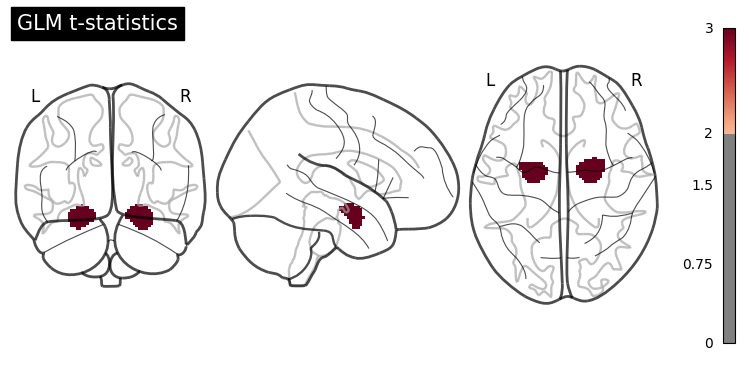

In [15]:
# 4. Visualize!
# Plot on glass brain
plotting.plot_glass_brain(
    results_img,
    colorbar=True,
    title='GLM t-statistics',
    plot_abs=False,
    threshold=2.0  # optional threshold
)


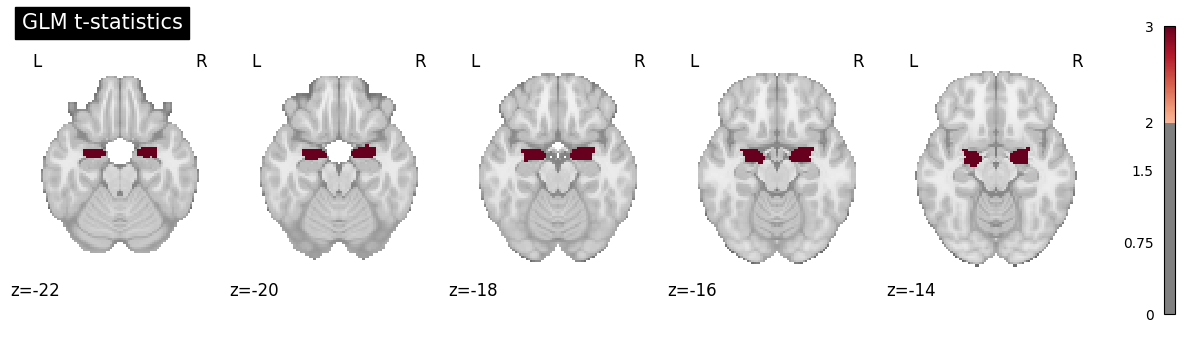

In [16]:

# Plot on anatomical slices
plotting.plot_stat_map(
    results_img,
    title='GLM t-statistics',
    threshold=2.0,
    display_mode='z',
    cut_coords=5
)


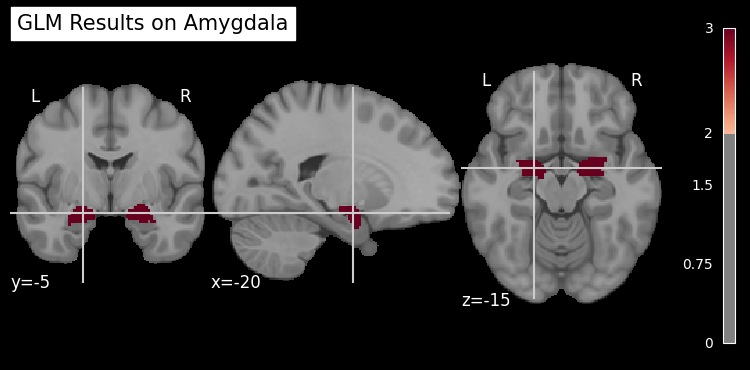

In [17]:
from nilearn import datasets

# Get an anatomical template
anat = datasets.load_mni152_template()

# Plot your results overlaid on anatomy
plotting.plot_stat_map(
    results_img,
    bg_img=anat,
    title='GLM Results on Amygdala',
    threshold=2.0,
    display_mode='ortho',
    cut_coords=(-20, -5, -15)  # MNI coordinates for amygdala
)